In [1]:
import tensorflow as tf

from qiskit import QuantumCircuit
from math import asin, sqrt, ceil
from qiskit.opflow import Z, CircuitStateFn, StateFn, PauliExpectation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Layer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
tf.executing_eagerly()

True

In [3]:
fano_data = pd.read_csv("./../datasets/signal_080_peak_1_fano_adjust.csv")

In [4]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [5]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

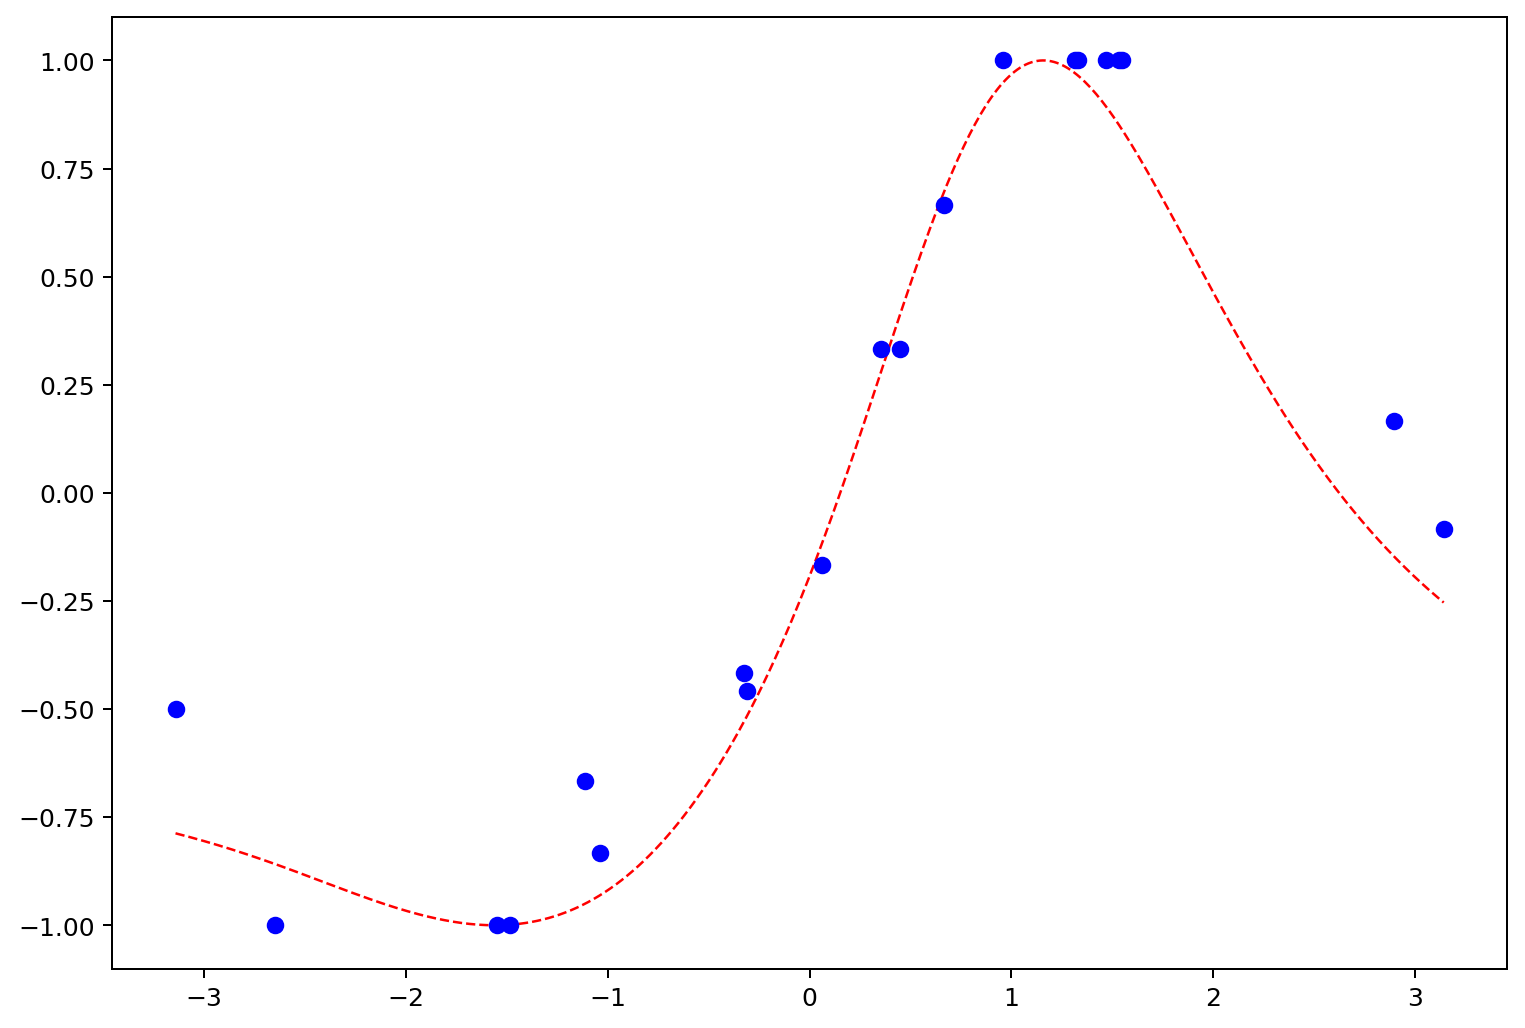

In [6]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

#XX = scale(XX, 0, 1)
XX = scale(XX) # from -pi to pi
yy = scale(yy, -1, 1)

#X_ = scale(X_, 0, 1)
X_ = scale(X_) # from -pi to pi
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

In [7]:
def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

In [8]:
def quantum_layer(initial_parameters, num_qubits):

    expectations = []
    
    for i in range(len(initial_parameters)):
        
        quantumCircuit = QuantumCircuit(num_qubits)

        quantumCircuit.h(range(num_qubits))
    
        angles = initial_parameters[i]
        
        for j in range(len(angles)):
            #quantumCircuit.ry(prob_to_angle(angles[j]), j)
            quantumCircuit.ry(angles[j] * np.pi, j)
            #quantumCircuit.ry(angles[j], j)

        quantumCircuit.h(range(num_qubits))
 
        operator = Z
        for _ in range(num_qubits - 1):
            operator @= Z
          
        psi = StateFn(quantumCircuit)
        #psi = CircuitStateFn(quantumCircuit)
        #expectation_value = psi.adjoint().compose(operator).compose(psi).eval() 
        expectation_value = (~psi @ operator @ psi).eval()
        #expectation_value = PauliExpectation().convert(expectation_value).eval()

        expectations.append(expectation_value)
 
    diff = num_qubits - len(expectations)
    
    if diff > 0:
        for _ in range(diff):
            expectations.append(0j)
    
    return expectations

In [9]:
class Linear(Layer):
    
    def __init__(self, output_size, batch_size = 10, units = 1, input_dim=1, num_qubits = 1, **kwargs):
        
        super(Linear, self).__init__(**kwargs)
        self.num_qubits = num_qubits
        self.output_size = output_size

        self.w = self.add_weight(
            shape=(input_dim, units), initializer="random_normal", trainable=True
        )
        
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)


    def build(self,input_shape): 
        self.input_size = input_shape[1]        
        self.w = self.add_weight(shape=(self.input_size,
                                          self.output_size),
                                   initializer='random_normal',
                                   trainable=True)

    def get_config(self):
        config = super(Linear, self).get_config()
        return config

    def call(self, inputs):
        
        if (tf.executing_eagerly()):
            
            final_output = []
        
            for i in range(inputs.shape[0]):
                pred = quantum_layer(inputs.numpy(), self.num_qubits)
                final_output.append(list(pred))

            return tf.convert_to_tensor(final_output)
        
        return inputs

In [10]:
n_qubits = 1

In [11]:
def sequential_model():

    layers_arr = []
    layers_arr.append(Dense(n_qubits, activation = 'relu', input_shape = [1], name = "dense1"))
    layers_arr.append(Linear(output_size = n_qubits, units = 1, input_dim = n_qubits, num_qubits = n_qubits, name = "quantum1"))
    layers_arr.append(Dense(n_qubits, activation="linear", name = "dense2"))
    layers_arr.append(Dense(1, name ="dense3"))

    return Sequential(layers_arr)

In [12]:
model = sequential_model()
    
#optimizer = Adam(learning_rate=0.01)
optimizer = SGD(learning_rate=0.01)

#model.compile(loss='mse', optimizer = optimizer, metrics = ['mae', 'mse', 'acc'], run_eagerly=True)
model.compile(optimizer, loss='mse', metrics=["accuracy"], run_eagerly=True)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 1)                 2         
_________________________________________________________________
quantum1 (Linear)            (None, 1)                 2         
_________________________________________________________________
dense2 (Dense)               (None, 1)                 2         
_________________________________________________________________
dense3 (Dense)               (None, 1)                 2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(XX, yy, epochs=50, batch_size=n_qubits, validation_split = 0.25)

#history = model.fit(XX, yy, epochs = 50, batch_size=n_qubits, validation_split = 0.25)

Epoch 1/50
15/15 [==============================] - 0s 17ms/step - loss: 2.8587 - accuracy: 0.0000e+00 - val_loss: 2.8089 - val_accuracy: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 16ms/step - loss: 1.3367 - accuracy: 0.0000e+00 - val_loss: 1.9725 - val_accuracy: 0.0000e+00
Epoch 3/50
14/15 [===========================>..] - ETA: 0s - loss: 1.0200 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.9796 - accuracy: 0.0000e+00 - val_loss: 1.5369 - val_accuracy: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 17ms/step - loss: 0.8002 - accuracy: 0.0000e+00 - val_loss: 1.2422 - val_accuracy: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 19ms/step - loss: 0.6853 - accuracy: 0.0000e+00 - val_loss: 1.0425 - val_accuracy: 0.0000e+00
Epoch 6/50
10/15 [===================>..........] - ETA: 0s - loss: 0.7181 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.6007 - accuracy: 0.0000e+00 - val_loss: 0.8907 - val_accuracy: 0.0000e+00
Epoch 7/50
15/15 [==============================] - 0s 17ms/step - loss: 0.5362 - accuracy: 0.0000e+00 - val_loss: 0.7472 - val_accuracy: 0.0000e+00
Epoch 8/50
15/15 [==============================] - 0s 16ms/step - loss: 0.4796 - accuracy: 0.0000e+00 - val_loss: 0.6150 - val_accuracy: 0.0000e+00
Epoch 9/50
10/15 [===================>..........] - ETA: 0s - loss: 0.4918 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.4282 - accuracy: 0.0000e+00 - val_loss: 0.5083 - val_accuracy: 0.0000e+00
Epoch 10/50
15/15 [==============================] - 0s 16ms/step - loss: 0.3819 - accuracy: 0.0000e+00 - val_loss: 0.4088 - val_accuracy: 0.0000e+00
Epoch 11/50
15/15 [==============================] - 0s 16ms/step - loss: 0.3384 - accuracy: 0.0000e+00 - val_loss: 0.3145 - val_accuracy: 0.0000e+00
Epoch 12/50
10/15 [===================>..........] - ETA: 0s - loss: 0.3279 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.3011 - accuracy: 0.0000e+00 - val_loss: 0.2546 - val_accuracy: 0.0000e+00
Epoch 13/50
15/15 [==============================] - 0s 16ms/step - loss: 0.2668 - accuracy: 0.0000e+00 - val_loss: 0.1942 - val_accuracy: 0.6000
Epoch 14/50
15/15 [==============================] - 0s 17ms/step - loss: 0.2353 - accuracy: 0.0667 - val_loss: 0.1419 - val_accuracy: 0.6000
Epoch 15/50
10/15 [===================>..........] - ETA: 0s - loss: 0.2396 - accuracy: 0.1000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.2126 - accuracy: 0.1333 - val_loss: 0.1330 - val_accuracy: 0.6000
Epoch 16/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1923 - accuracy: 0.1333 - val_loss: 0.1255 - val_accuracy: 0.6000
Epoch 17/50
15/15 [==============================] - 0s 17ms/step - loss: 0.1781 - accuracy: 0.1333 - val_loss: 0.1053 - val_accuracy: 0.6000
Epoch 18/50
 9/15 [=================>............] - ETA: 0s - loss: 0.1379 - accuracy: 0.1111WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.1666 - accuracy: 0.1333 - val_loss: 0.1054 - val_accuracy: 0.6000
Epoch 19/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1573 - accuracy: 0.2000 - val_loss: 0.1057 - val_accuracy: 0.6000
Epoch 20/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1507 - accuracy: 0.2000 - val_loss: 0.1090 - val_accuracy: 0.6000
Epoch 21/50
10/15 [===================>..........] - ETA: 0s - loss: 0.1153 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.1452 - accuracy: 0.2000 - val_loss: 0.1090 - val_accuracy: 0.6000
Epoch 22/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1443 - accuracy: 0.2000 - val_loss: 0.1289 - val_accuracy: 0.6000
Epoch 23/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1414 - accuracy: 0.2000 - val_loss: 0.1440 - val_accuracy: 0.6000
Epoch 24/50
10/15 [===================>..........] - ETA: 0s - loss: 0.1095 - accuracy: 0.1000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.1395 - accuracy: 0.2000 - val_loss: 0.1461 - val_accuracy: 0.6000
Epoch 25/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1395 - accuracy: 0.2000 - val_loss: 0.1522 - val_accuracy: 0.6000
Epoch 26/50
15/15 [==============================] - 0s 20ms/step - loss: 0.1383 - accuracy: 0.2000 - val_loss: 0.1566 - val_accuracy: 0.6000
Epoch 27/50
 5/15 [=========>....................] - ETA: 0s - loss: 0.0651 - accuracy: 0.4000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.1380 - accuracy: 0.2000 - val_loss: 0.1614 - val_accuracy: 0.6000
Epoch 28/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1371 - accuracy: 0.2000 - val_loss: 0.1770 - val_accuracy: 0.6000
Epoch 29/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1376 - accuracy: 0.2000 - val_loss: 0.1733 - val_accuracy: 0.6000
Epoch 30/50
 5/15 [=========>....................] - ETA: 0s - loss: 0.1073 - accuracy: 0.2000    WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.1371 - accuracy: 0.2000 - val_loss: 0.1790 - val_accuracy: 0.6000
Epoch 31/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1351 - accuracy: 0.2000 - val_loss: 0.1951 - val_accuracy: 0.6000
Epoch 32/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1380 - accuracy: 0.2000 - val_loss: 0.1878 - val_accuracy: 0.6000
Epoch 33/50
 6/15 [===========>..................] - ETA: 0s - loss: 0.1448 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.1374 - accuracy: 0.2000 - val_loss: 0.1840 - val_accuracy: 0.6000
Epoch 34/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1364 - accuracy: 0.2000 - val_loss: 0.1956 - val_accuracy: 0.6000
Epoch 35/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1373 - accuracy: 0.2000 - val_loss: 0.1862 - val_accuracy: 0.6000
Epoch 36/50
 6/15 [===========>..................] - ETA: 0s - loss: 0.2045 - accuracy: 0.3333WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.1377 - accuracy: 0.2000 - val_loss: 0.1849 - val_accuracy: 0.6000
Epoch 37/50
15/15 [==============================] - 0s 18ms/step - loss: 0.1375 - accuracy: 0.2000 - val_loss: 0.1832 - val_accuracy: 0.6000
Epoch 38/50
15/15 [==============================] - 0s 18ms/step - loss: 0.1366 - accuracy: 0.2000 - val_loss: 0.1797 - val_accuracy: 0.6000
Epoch 39/50
 5/15 [=========>....................] - ETA: 0s - loss: 0.1439 - accuracy: 0.4000WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 18ms/step - loss: 0.1377 - accuracy: 0.2000 - val_loss: 0.1798 - val_accuracy: 0.6000
Epoch 40/50
15/15 [==============================] - 0s 18ms/step - loss: 0.1373 - accuracy: 0.2000 - val_loss: 0.1914 - val_accuracy: 0.6000
Epoch 41/50
15/15 [==============================] - 0s 18ms/step - loss: 0.1377 - accuracy: 0.2000 - val_loss: 0.1895 - val_accuracy: 0.6000
Epoch 42/50
 1/15 [=>............................] - ETA: 0s - loss: 0.3901 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 17ms/step - loss: 0.1366 - accuracy: 0.2000 - val_loss: 0.1989 - val_accuracy: 0.6000
Epoch 43/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1357 - accuracy: 0.2000 - val_loss: 0.2046 - val_accuracy: 0.6000
Epoch 44/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1363 - accuracy: 0.2000 - val_loss: 0.1860 - val_accuracy: 0.6000
Epoch 45/50
 1/15 [=>............................] - ETA: 0s - loss: 0.0975 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.1365 - accuracy: 0.2000 - val_loss: 0.1809 - val_accuracy: 0.6000
Epoch 46/50
15/15 [==============================] - 0s 18ms/step - loss: 0.1378 - accuracy: 0.2000 - val_loss: 0.1884 - val_accuracy: 0.6000
Epoch 47/50
15/15 [==============================] - 0s 18ms/step - loss: 0.1363 - accuracy: 0.2000 - val_loss: 0.1826 - val_accuracy: 0.6000
Epoch 48/50
 1/15 [=>............................] - ETA: 0s - loss: 0.0024 - accuracy: 0.0000e+00WARNING:tensorflow:Gradients do not exist for variables ['dense1/kernel:0', 'dense1/bias:0', 'Variable:0', 'quantum1/Variable:0'] when minimizing the loss.


15/15 [==============================] - 0s 16ms/step - loss: 0.1370 - accuracy: 0.2000 - val_loss: 0.1825 - val_accuracy: 0.6000
Epoch 49/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1375 - accuracy: 0.2000 - val_loss: 0.1887 - val_accuracy: 0.6000
Epoch 50/50
15/15 [==============================] - 0s 16ms/step - loss: 0.1370 - accuracy: 0.2000 - val_loss: 0.1843 - val_accuracy: 0.6000


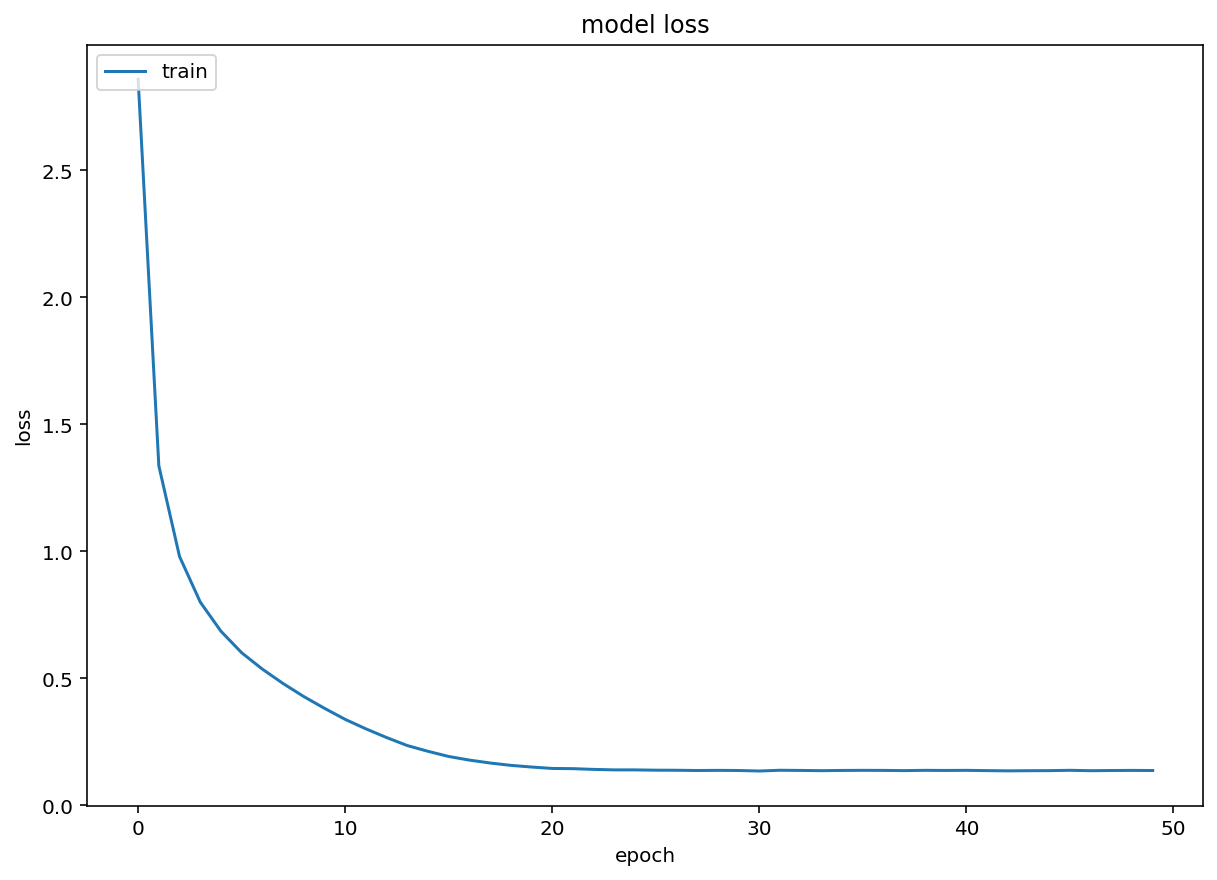

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [16]:
def split_batch_predict(data, num_qubits, model):
    
    splitted_X = None

    if num_qubits > 1:
        num_sections = ceil(X_.shape[0] / num_qubits)
        splitted_X = np.array_split(data.flatten(), num_sections)
    else:
        splitted_X = data

    y_prediction = []

    for arr in splitted_X:
        pred = model.predict(arr)
        y_prediction.append(pred.tolist())
    
    return np.array(y_prediction)

In [17]:
y_predict = split_batch_predict(X_, n_qubits, model)

In [18]:
y_predict_smooth = smooth(y_predict)

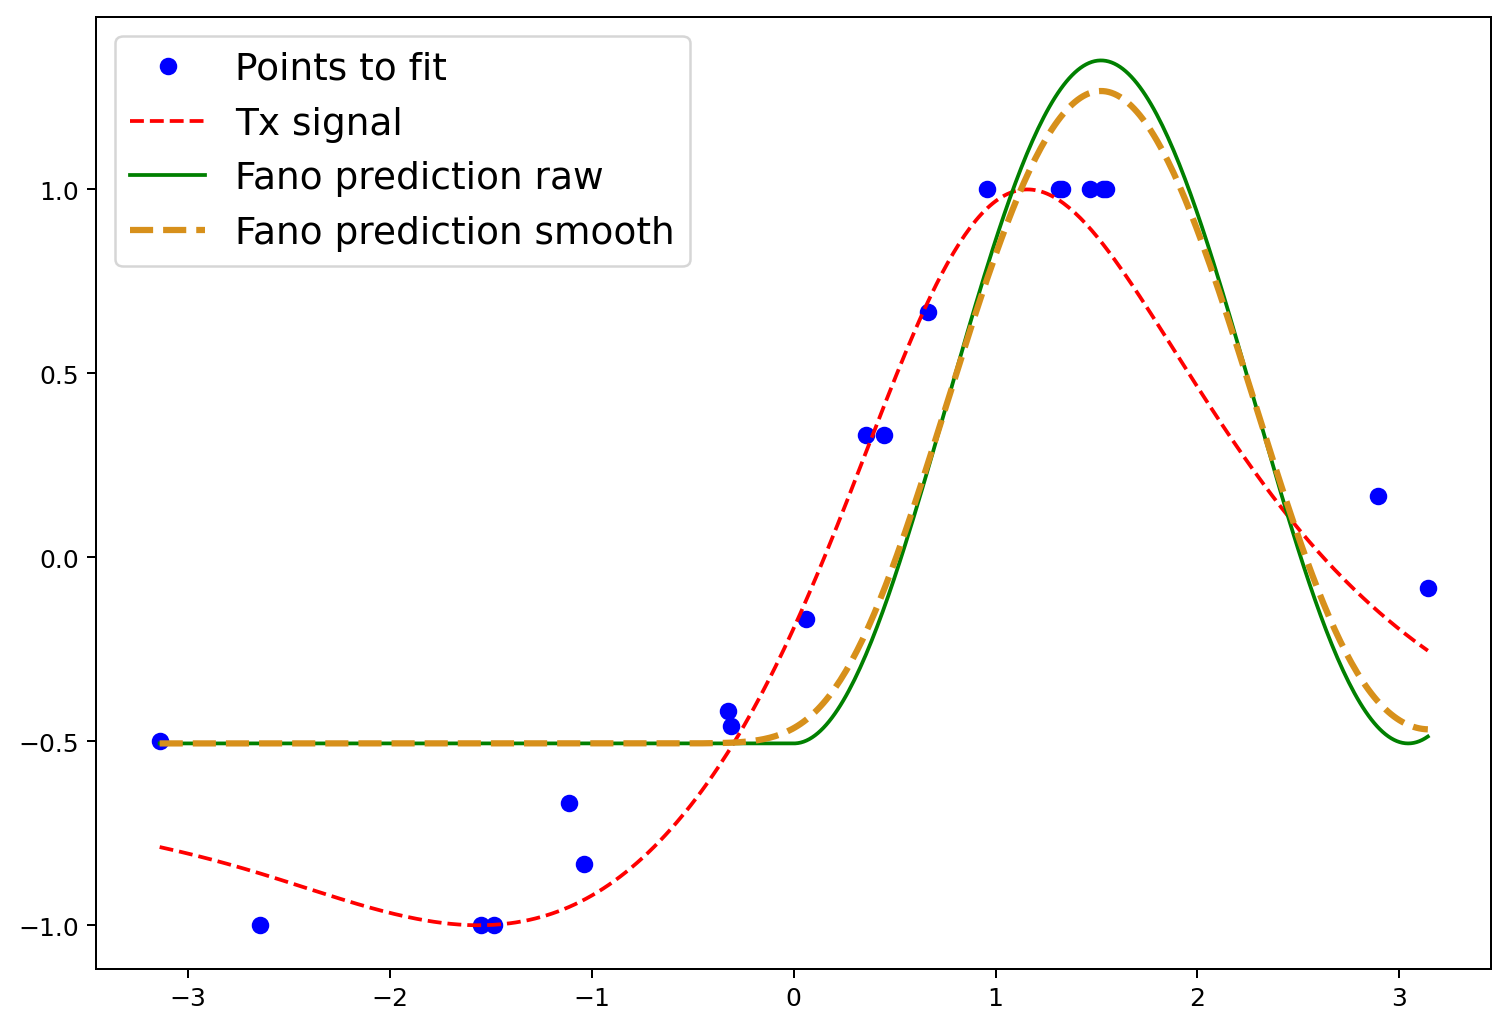

In [19]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(XX, yy, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict.flatten(), "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth.flatten(), "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [20]:
print("Score: %.10f" % r2_score(y_, y_predict.flatten()))

Score: 0.7105870368
